In [2]:
import mdtraj as md
import numpy as np
import pandas as pd
import random, os, math, tqdm, pickle
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from realsys_utils import *
from datetime import datetime
import yaml, pickle, tqdm, glob
from muller_utils import (find_region_change, 
                          deepest_well_escape_frame, 
                          success_cluster_identification, 
                          reconstruct_energy)
from realsys_utils import find_shift_index

In [3]:
#directory = 'results/peptide/ogn/run_240212_1831'
# directory = 'results/peptide/ogn/run_240213_2314'
directory = 'results/peptide/ogn/run_240216_1637' #'results/peptide/ogn/run_240214_2034'
directory_base = 'results/peptide/base'
params = yaml.load(open(os.path.join(directory,'param.yaml'), 'r'), Loader=yaml.FullLoader)
init_traj_index = params['init_traj_index']
large_batch_size = params['large_batch_size']
small_batch_size = params['small_batch_size']
threshold = params['threshold']
feature1_path = params['feature1_path']
feature2_path = params['feature2_path']
feature1 = pd.read_pickle(feature1_path) # a9
feature2 = pd.read_pickle(feature2_path) #20
traj = combine_trajectories(feature1, feature2)


result = pd.read_pickle(os.path.join(directory,'results.pkl'))
all_traj = result['all_traj']
all_traj_stacked = np.vstack(all_traj)
outer = result['outer']
inner = result['inner']
iteration_counter = result['iteration_counter']
iteration_counter_list = iteration_counter_converter(iteration_counter)
coord_index = result['coord_index']

In [4]:
proposed_inits, new_inits, prev_lasts, updates = get_data_for_figures(inner)

In [5]:
center_points = np.array([[1.61, 2.52], [2.45, 2.52], 
                          [1.6, 1.67], [2.47, 1.67]])

x_limits = [1.25, 2.95]
y_limits = [1.25, 2.95]
x_label='A9 O-C-N angle (rad)'
y_label='R20 O-C-C angle (rad)'
ft=15
label_1 = 'MD'
label_2 = 'GradNav'

# MD

## Trajectory

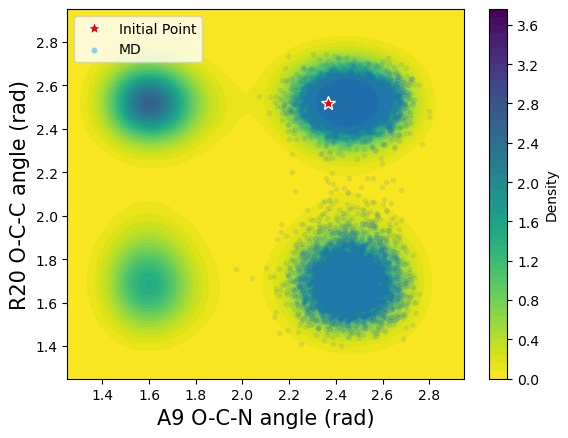

In [5]:
#init_traj_index = 4 #15
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
plt.scatter(traj[init_traj_index][:,0], traj[init_traj_index][:,1], 
            marker='.', 
            #edgecolors='blue',
            alpha=0.1) #, c='orange')
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c='skyblue', label=label_1, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.legend(fontsize=ft-5, loc='upper left')

plt.savefig(os.path.join(directory_base, 'all_data_MD.png'), 
            dpi=300, bbox_inches='tight')

## DWEF

In [68]:
# Initialize the list and average calculation
switching_index_list = [2, 3, 6, 7, 8, 9, 13, 15, 19, 22, 23, 26, 28]

dwe_frame_avg = 0 
output_lines = []  # List to hold output lines for writing to file

for idx in switching_index_list:
    dwe_frame = find_shift_index(traj[idx], 'x', 1.9)
    output_lines.append(f'Run {idx}: {dwe_frame}\n')
    dwe_frame_avg += dwe_frame
dwe_frame_avg = dwe_frame_avg / len(switching_index_list)
output_lines.append(f'Average DWEF: {dwe_frame_avg}\n')

# Writing results to a text file
with open(os.path.join(directory_base, 'dwef.txt'), 'w') as file:
    file.writelines(output_lines)

## SSIR

In [83]:
total_num_success = 0
total_num_clusters = 0
valid_init = []

for i in tqdm.tqdm(range(1,29)):
    init = traj[i][0]
    num_identified_cluster = success_cluster_identification(traj[i], 
                                                            center_points, 
                                                            distance_threshold=0.1, 
                                                            number_threshold=5)
    total_num_success += num_identified_cluster
    total_num_clusters += len(center_points)
    init = np.append(init, num_identified_cluster)
    valid_init.append(init)

valid_init = np.array(valid_init)
ssir = total_num_success / total_num_clusters 

# save ssir and valid_init
with open(os.path.join(directory_base, 'ssir_md.txt'), 'w') as f:
    f.write(f'{ssir:.3f}')

with open(os.path.join(directory_base, 'valid_init_md.pkl'), 'wb') as f:
    pickle.dump(valid_init, f)

100%|██████████| 28/28 [00:03<00:00,  7.52it/s]


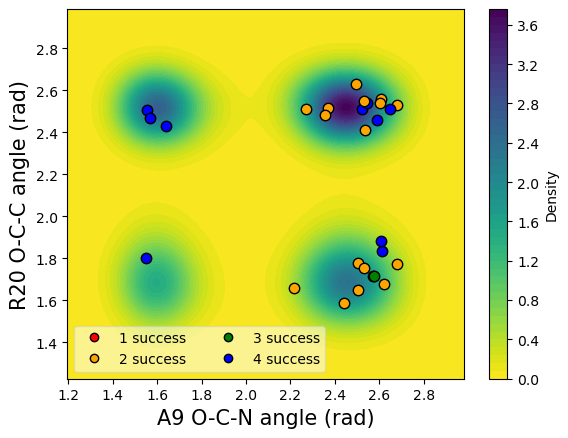

In [84]:
# Define colors for each value
colors = {1: 'red', 2: 'orange', 3: 'green', 4: 'blue'}

density_contour(traj[15], xlabel=x_label, ylabel=y_label)

# Loop through each point and plot it with the corresponding color
for point in valid_init:
    plt.plot(point[0], point[1], '.', 
             color=colors[point[-1]], markeredgecolor='black', markersize=15)
    # plt.text(point[0], point[1], f'{point[3]}', color='black', fontsize=9, ha='right', va='bottom')
    #plt.text(point[0], point[1], f'{int(point[3])}', color='black', fontsize=11) #, ha='right', va='bottom')
for i in range(len(colors)):
    plt.plot([], [], '.', color=list(colors.values())[i], 
             markeredgecolor='black', markersize=12, label=f'{i+1} success')
plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5, ncol=2)

plt.savefig(os.path.join(directory_base, 'ssir_md.png'), 
            dpi=300, bbox_inches='tight')

In [ ]:
# right region start
# 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
# 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28
## switch showing
# 2, 3, 6, 7, 8, 9, 13, 15, 19, 22, 23, 26, 28


In [65]:
# # frame_no = 50
# # number = 15
# for i in range(1, 29):
#     #colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
#     # density_contour(traj[15], xlabel=x_label, ylabel=y_label)
#     plt.plot(all_traj[0][0, 0], all_traj[0][0, 1], '*', 
#              markeredgecolor='white', color='r', 
#              markersize=10, label='Initial Point')

#     plt.scatter(traj[i][:,0], 
#                 traj[i][:,1], 
#                 marker='.', 
#                 #edgecolors='blue',
#                 alpha=0.1) 

#     plt.xlim(x_limits)
#     plt.ylim(y_limits)
#     plt.xlabel(x_label, fontsize=ft)
#     plt.ylabel(y_label, fontsize=ft)
#     plt.savefig(os.path.join(directory_base, f'traj/traj_{i}.png'), 
#                             dpi=300, bbox_inches='tight')
#     plt.close()

# All data

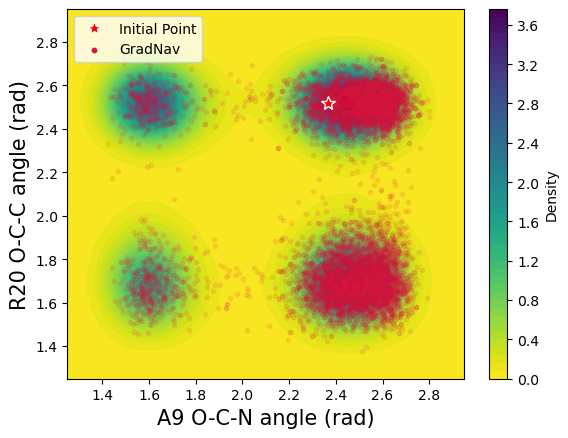

In [6]:
# init_traj_index = 4 #15
color = 'crimson'
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
plt.scatter(all_traj_stacked[:,0], all_traj_stacked[:,1], 
            marker='.', 
            #edgecolors='blue',
            c=color,
            alpha=0.1) 
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c=color, label=label_2, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.legend(fontsize=ft-5, loc='upper left')

plt.savefig(os.path.join(directory, 'all_data_OGN.png'), 
            dpi=300, bbox_inches='tight')

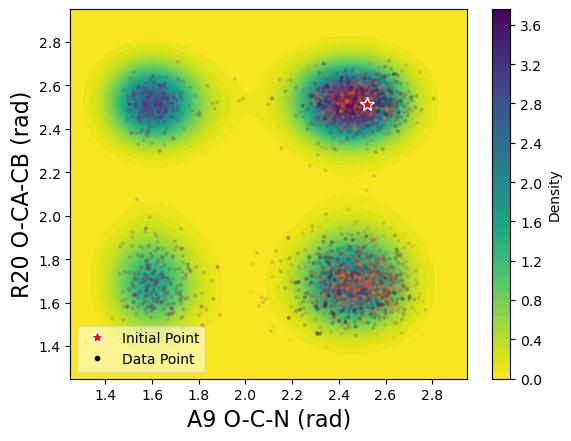

In [67]:
# colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
# density_contour(traj[15], xlabel=x_label, ylabel=y_label)
# plt.plot(all_traj[0][0, 0], all_traj[0][0, 1], '*', 
#          markeredgecolor='white', color='r', 
#          markersize=10, label='Initial Point')
# i=0
# for n in range(len(all_traj)): 
#     c = colors[n]
#     x = all_traj[n][:,0]
#     y = all_traj[n][:,1]
#     plt.scatter(x, y, edgecolor='none', s=8, color=c, alpha=0.2) #, label=f'Run {i+1}')
#     i += 1

# plt.xlim(x_limits[0], x_limits[1])
# plt.ylim(y_limits[0], y_limits[1])

# # plt.plot([], [], '*', c='r', label='Initial Point')
# plt.plot([], [], '.', c='k', label='Data Point')  # 'o' for circle markers

# plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)

# # plt.legend(fontsize=ft-5, loc='lower left')
# # plt.savefig(os.path.join(directory,'all_points.png'), bbox_inches='tight', facecolor='w')
# plt.savefig(os.path.join(directory, 'all_data_OGN_type2.png'), 
#             dpi=300, bbox_inches='tight')

# Outer loop trajectories

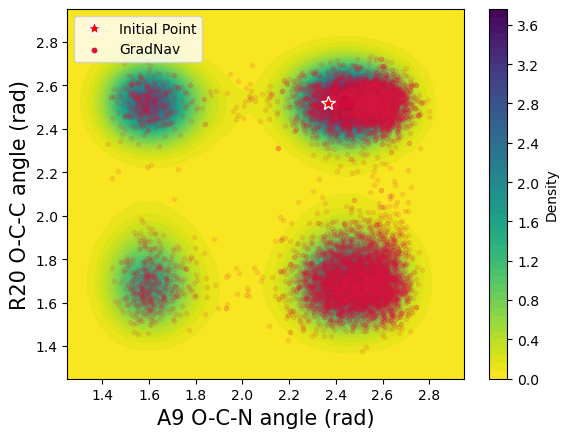

In [7]:
outer_loop_trajs = [all_traj[start_index] for start_index, _ in iteration_counter_list]
outer_loop_trajs = np.vstack(outer_loop_trajs)


color = 'crimson'
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
plt.scatter(outer_loop_trajs[:,0], outer_loop_trajs[:,1], 
            marker='.', 
            #edgecolors='blue',
            c=color,
            alpha=0.1) 
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c=color, label=label_2, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.legend(fontsize=ft-5, loc='upper left')

plt.savefig(os.path.join(directory, 'outer_data_OGN.png'), 
            dpi=300, bbox_inches='tight')

# DWEF

In [8]:
shift_threshold = 1.8
number_threshold = 20

dwef_ogn = find_shift_index(outer_loop_trajs, 'x', shift_threshold, number_threshold)
print(dwef_ogn)

# save results
with open(os.path.join(directory, f'dwef{dwef_ogn}.txt'), 'w') as file:
    file.write(f'{dwef_ogn}\n')

3065


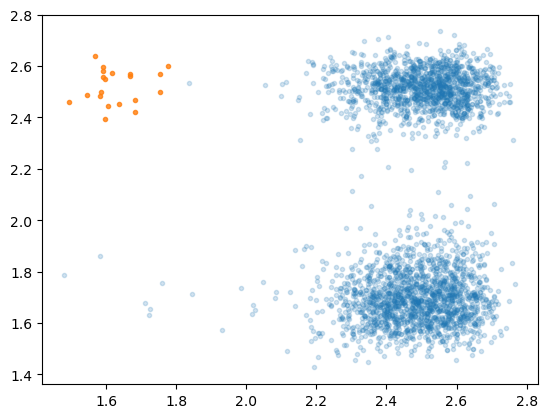

In [9]:
n_frame = dwef_ogn
plt.plot(outer_loop_trajs[:n_frame, 0], 
         outer_loop_trajs[:n_frame, 1], 
         '.', alpha=0.2)
plt.plot(outer_loop_trajs[n_frame:n_frame+number_threshold, 0], 
         outer_loop_trajs[n_frame:n_frame+number_threshold, 1], 
         '.', alpha=0.8)

In [172]:
# shift_threshold = 1.8
# number_threshold = 20

# dwef_ = find_shift_index(traj[15], 'x', shift_threshold, number_threshold)
# print(dwef_)

6326


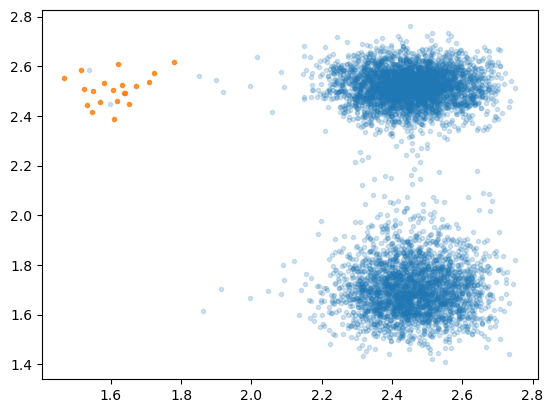

In [173]:
# n_frame = dwef_
# addition = 5000
# plt.plot(traj[15][:n_frame, 0], 
#          traj[15][:n_frame, 1], 
#          '.', alpha=0.2)
# plt.plot(traj[15][n_frame:n_frame+number_threshold, 0], 
#          traj[15][n_frame:n_frame+number_threshold, 1], 
#          '.', alpha=0.8)

# Update rate

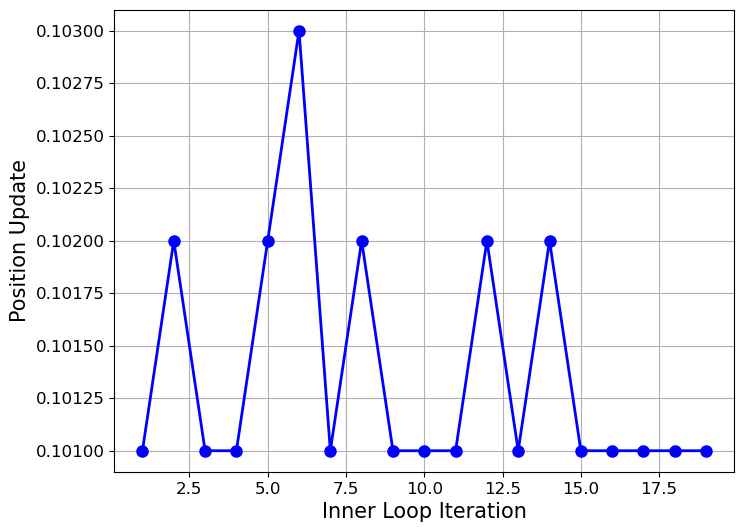

In [10]:
# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
iteration = np.arange(1, len(updates) + 1)
plt.plot(iteration, updates, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Add labels and title
plt.xlabel('Inner Loop Iteration', fontsize=15)
plt.ylabel('Position Update', fontsize=15)
# plt.title('Position Update vs. Iteration', fontsize=16)

# Increase the tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Save the plot as an image (optional)
plt.savefig(os.path.join(directory, 'update_rate.png'), 
            dpi=300, bbox_inches='tight')

# Update arrow (proposed)

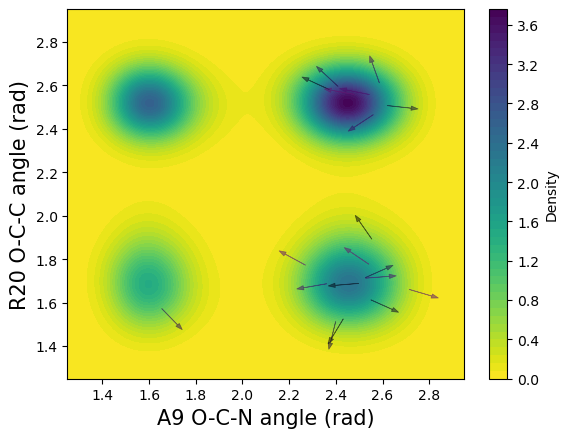

In [11]:
colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
i = 0
for prev, upd in zip(prev_lasts, proposed_inits): 
    c = colors[i]
    x_prev, y_prev = prev
    x_upd, y_upd = upd
    plt.arrow(x_prev, y_prev, x_upd-x_prev, y_upd-y_prev, 
              color=c, head_width = .02, linewidth=0.5, alpha=0.5)
    i += 1
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.savefig(os.path.join(directory, 'arrow_proposed.png'), 
            dpi=300, bbox_inches='tight')

# Update arrow (actual)

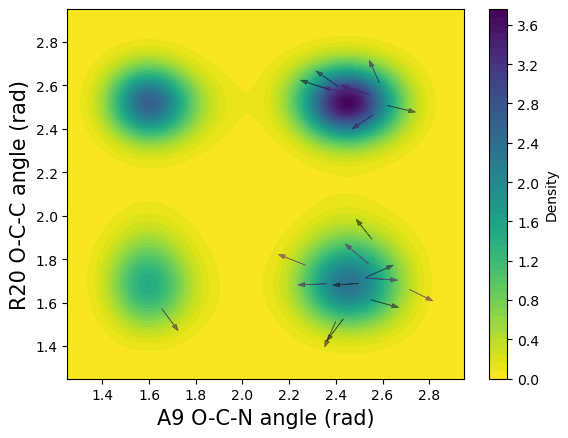

In [12]:
colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
i = 0
for prev, upd in zip(prev_lasts, new_inits): 
    c = colors[i]
    x_prev, y_prev = prev
    x_upd, y_upd = upd
    plt.arrow(x_prev, y_prev, x_upd-x_prev, y_upd-y_prev, 
              color=c, head_width = .02, linewidth=0.5, alpha=0.5)
    i += 1
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.savefig(os.path.join(directory, 'arrow_actual.png'), 
            dpi=300, bbox_inches='tight')

# Descrepancy between proposed and actual inits

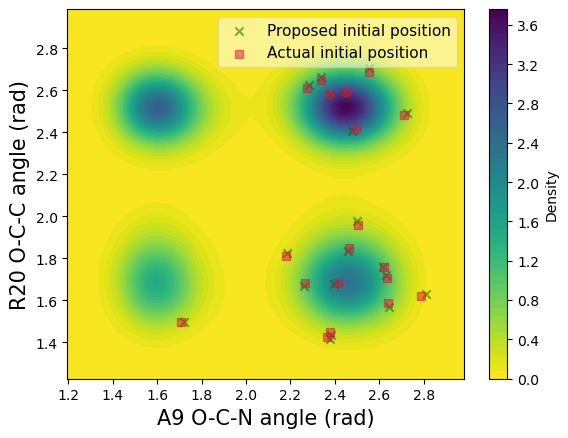

In [13]:
density_contour(traj[15], xlabel=x_label, ylabel=y_label)
#plt.scatter(prev_lasts[:,0], prev_lasts[:,1], color='blue', marker='.', label='prev last')
plt.scatter(proposed_inits[:,0], proposed_inits[:,1], color='darkgreen', alpha=0.5, marker='x', label='Proposed initial position')
plt.scatter(new_inits[:,0], new_inits[:,1], color='crimson', marker='s', alpha=0.5, label='Actual initial position')
plt.legend(fontsize=ft-4, loc='best', framealpha=0.5)
plt.savefig(os.path.join(directory, 'init_delta.png'), 
            dpi=300, bbox_inches='tight')

# Energy Curve Reconstruction

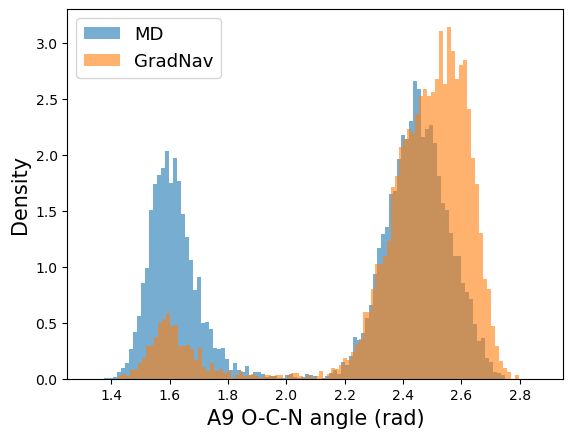

In [15]:
base_index = 15 #init_traj_index
plt.hist(traj[base_index][:,0], bins=100, density=True, 
         alpha=0.6, label=label_1)
plt.hist(all_traj_stacked[:,0], bins=100, density=True, alpha=0.6, 
         label=label_2)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel('Density', fontsize=ft)
plt.xlim(y_limits)
# plt.title('Distribution of Distance from Start Point')
plt.legend(fontsize=ft-2, loc='best')
plt.savefig(os.path.join(directory, f'histogram_md{base_index}.png'), 
            dpi=300, bbox_inches='tight')


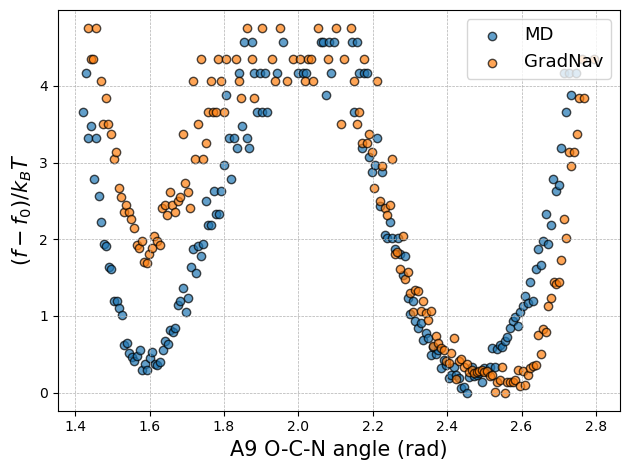

In [17]:
base_index = 15 #init_traj_index
anchors_md, fn_md = reconstruct_energy(traj[base_index][:,0], 200)
anchors_ogn, fn_ogn = reconstruct_energy(all_traj_stacked[:,0], 200)

# Visualize the results with improved aesthetics
plt.scatter(anchors_md, fn_md, alpha=0.7, edgecolor='black', label=label_1)
plt.scatter(anchors_ogn, fn_ogn, alpha=0.7, edgecolor='black', label=label_2)

plt.xlabel(x_label, fontsize=ft)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize=ft)

# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(fontsize=ft-2, loc='upper right')
plt.savefig(os.path.join(directory, f'recon_E_md{base_index}.png'), 
            dpi=300, bbox_inches='tight')

# SSIR - Initial points on grid

(1.25, 2.95)

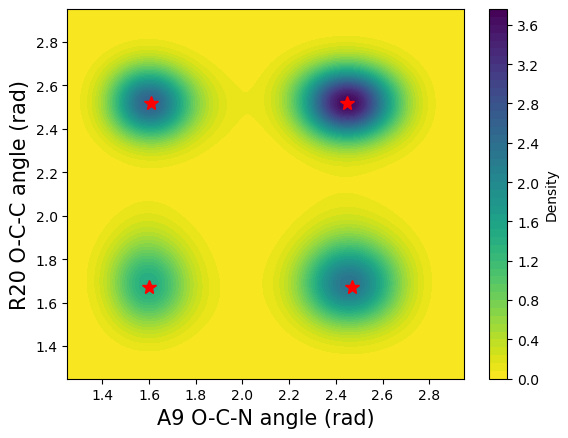

In [18]:
density_contour(traj[15], xlabel=x_label, ylabel=y_label)


for i in range(center_points.shape[0]):
    plt.plot(center_points[i, 0], center_points[i, 1], '*', color='r', markersize=10)

plt.xlim(x_limits)
plt.ylim(y_limits)

In [89]:
command = f"python run_ssir_realsys_ogn.py --dir {directory.split('/')[-1]} --last_index 28"
!{command}

  0%|                                                    | 0/28 [00:00<?, ?it/s]simulation initialization
1600 frames remain!
cluster transition 1!
1200 frames remain!
cluster transition 2!
800 frames remain!
cluster transition 3!
360 frames remain!
cluster transition 4!
-40 frames remain!
cluster transition 5!
simulation termination
  4%|█▌                                          | 1/28 [00:03<01:27,  3.24s/it]simulation initialization
1600 frames remain!
cluster transition 1!
1200 frames remain!
cluster transition 2!
800 frames remain!
cluster transition 3!
360 frames remain!
cluster transition 4!
-40 frames remain!
cluster transition 5!
simulation termination
  7%|███▏                                        | 2/28 [00:04<00:56,  2.17s/it]simulation initialization
1600 frames remain!
cluster transition 1!
1200 frames remain!
cluster transition 2!
800 frames remain!
cluster transition 3!
400 frames remain!
cluster transition 4!
0 frames remain!
cluster transition 5!
simulation termin

In [90]:
total_num_success = 0
total_num_clusters = 0
valid_init = []
# path = "results/peptide/ogn/ssir_240212_2053"
#for i in tqdm.tqdm(range(1,5)):
for file in glob.glob(os.path.join(directory, 'ssir', 'traj_*', 'results.pkl')):
    results = pd.read_pickle(file)
    
    iter_traj = results['all_traj']
    iter_traj = np.vstack(iter_traj)
    
    init = iter_traj[0]
    num_identified_cluster = success_cluster_identification(iter_traj, 
                                                            center_points, 
                                                            distance_threshold=0.1, 
                                                            number_threshold=5)
    total_num_success += num_identified_cluster
    total_num_clusters += len(center_points)
    init = np.append(init, num_identified_cluster)
    valid_init.append(init)

valid_init = np.array(valid_init)
ssir = total_num_success / total_num_clusters 
print(ssir)

0.7142857142857143


In [91]:
# save ssir and valid_init
with open(os.path.join(directory, 'ssir_ogn.txt'), 'w') as f:
    f.write(f'{ssir:.3f}')

with open(os.path.join(directory, 'valid_init_ogn.pkl'), 'wb') as f:
    pickle.dump(valid_init, f)

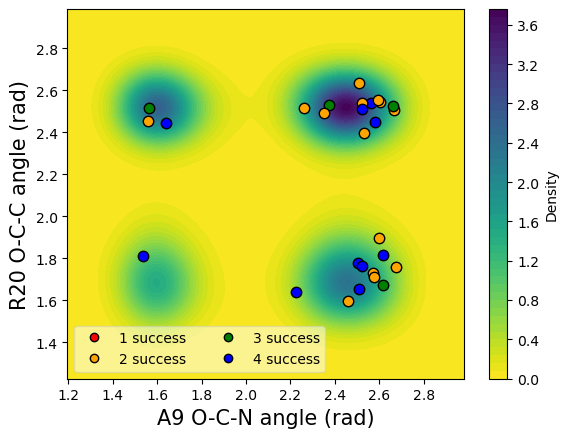

In [92]:
# Define colors for each value
colors = {1: 'red', 2: 'orange', 3: 'green', 4: 'blue'}

density_contour(traj[15], xlabel=x_label, ylabel=y_label)

# Loop through each point and plot it with the corresponding color
for point in valid_init:
    plt.plot(point[0], point[1], '.', 
             color=colors[point[-1]], markeredgecolor='black', markersize=15)
    # plt.text(point[0], point[1], f'{point[3]}', color='black', fontsize=9, ha='right', va='bottom')
    #plt.text(point[0], point[1], f'{int(point[3])}', color='black', fontsize=11) #, ha='right', va='bottom')
for i in range(len(colors)):
    plt.plot([], [], '.', color=list(colors.values())[i], 
             markeredgecolor='black', markersize=12, label=f'{i+1} success')
plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5, ncol=2)

plt.savefig(os.path.join(directory, 'ssir_ogn.png'), 
            dpi=300, bbox_inches='tight')

# RMSD Plot

In [93]:
count_traj15 = 0
for i in range(len(coord_index)):
    (traj_num, start_idx, end_idx) = coord_index[i]
    if traj_num == 15:
        count_traj15 +=1
print(count_traj15)

1


In [22]:
# Placeholder list to store each extracted segment of trajectories
topology_file = "/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/fs-peptide.pdb"

extracted_segments = []
# Loop through each item in your target indices dictionary
for (traj_num, start_idx, end_idx) in coord_index:
    if end_idx - start_idx == large_batch_size:
        # Construct the XTC filename for the current trajectory
        filename = f"/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/trajectory-{traj_num}.xtc"
        # Load the entire trajectory first
        traj = md.load_xtc(filename, top=topology_file)
        # Extract the frames within the target indices
        # Adjust indexing as necessary based on whether your frame indices are 0-based or 1-based
        segment = traj[start_idx:end_idx+1]
        # Append the extracted segment to the list
        extracted_segments.append(segment)

# Concatenate all extracted segments into a single trajectory
combined_traj = md.join(extracted_segments)


# Save the combined trajectory to a new XTC file
combined_traj.save_xtc(os.path.join(directory,"combined_trajectory.xtc"))

In [6]:
# read trajs md.load_pdb
topology_file = "/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/fs-peptide.pdb"
topology_fn = md.load_pdb(topology_file)
traj_ogn = md.load_xtc(os.path.join(directory,"combined_trajectory.xtc"), top=topology_file)
traj_md = md.load('/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/trajectory-15.xtc', top=topology_file)
traj_ogn = traj_ogn[:len(traj_md)]

print('Length of traj_md:', len(traj_md))
print('Length of traj_ogn:', len(traj_ogn))

rmsd_md = md.rmsd(traj_md, topology_fn, 0) # rmsd_md = md.rmsd(traj_md, traj_md, 0)
rmsd_ogn = md.rmsd(traj_ogn, topology_fn, 0) # rmsd_ogn = md.rmsd(traj_ogn, traj_ogn, 0)


/home/hoon/anaconda3/envs/openmm/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Length of traj_md: 10000
Length of traj_ogn: 9331


In [9]:
directory

'results/peptide/ogn/run_240216_1637'

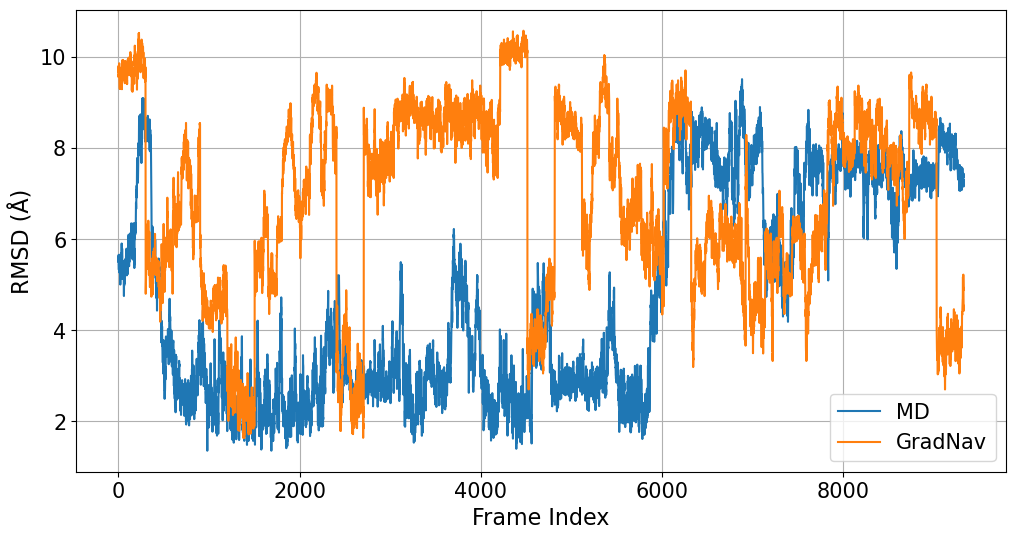

In [8]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(10*rmsd_md[:len(rmsd_ogn)], label=label_1)
plt.plot(10*rmsd_ogn, label=label_2)
plt.xlabel('Frame Index', fontsize=ft+1)
plt.ylabel('RMSD (Å)', fontsize=ft+1)
# plt.title('RMSD Over Iterations')
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.legend(fontsize=ft)
plt.grid(True)
plt.savefig(os.path.join(directory, 'rmsd_2.png'),dpi=300, bbox_inches='tight')